# Terse version of SWH calculation

This is the stripped down (procedural) version of what would be done to calulate the significant wave height for one buoy (after having already retreived the data).

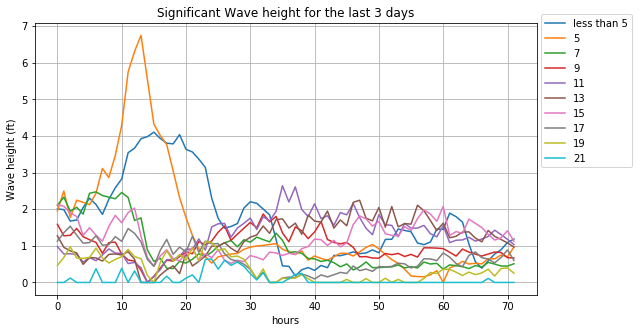

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

filename = '46053' # the buoy name
dest = './data/{}.data_spec'.format(filename)

dates = []
energies = []
frequencies = []

with open(dest) as fp:
    for _ in range(3):
        next(fp)    
    for l in fp:
        dates.append(l.split()[0:5])
        energies.append([float(e) for e in l.split()[6::2]])
        freqs=l.split()[7::2]
        frequencies.append([float(i[1:-1]) for i in freqs])
    fp.close()

E = np.array(energies)    # E for 'Energy'
f = np.array(frequencies) # f for 'frequency'
df = np.diff(f)
fmid = .5*(f[:,:-1] + f[:,1:]) 
Emid = .5*(E[:,:-1] + E[:,1:]) 

p = np.array([0,5,7,9,11,13,15,17,19,21,35])
pmid = .5*(p[1:] + p[:-1])

Pf = 1./fmid[0,:]
Pf

fig, ax = plt.subplots()
plt.gca().invert_xaxis()

fig.set_size_inches(9,5)

for idx, _ in enumerate(pmid):
    period_mask = (Pf > p[idx]) & (Pf <= p[idx+1])
    df_subset = df[:,period_mask]
    Emid_subset = Emid[:,period_mask]
    product = (df_subset*Emid_subset)
    SWH = (4*np.sqrt(product.sum(axis=1)))
    if idx == 0:
        label = 'less than 5'
    else:
        label = p[idx]
    ax.plot((SWH[0:72]*3.28),label=label)


plt.gca().invert_xaxis()
ax.set(xlabel='hours', ylabel='Wave height (ft)',
       title='Significant Wave height for the last 3 days')
ax.legend(bbox_to_anchor=(1.2, 1.05))
ax.grid()
